# Nathan Notebook
Experimentation with preprocessing, binary classification, multiclassification

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# Tensorflow/keras imports
from keras import Sequential
from keras import layers
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

In [3]:
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

In [4]:
# Data files
# Train
train_df = pd.read_csv("UNSW_NB15_training-set.csv")
# Test
test_df = pd.read_csv("UNSW_NB15_testing-set.csv")

## Preprocessing

### Initial Preprocessing: Missing values, Outliers, Shuffle, Covering types, Removing irrelevant features, Preparing X y

In [5]:
# Note: There are no missing values in the train or test sets
# Train
# train_df = train_df.dropna() # All entries are complete in original data
# Test
# test_df = test_df.dropna() # All entries are complete in original data

In [6]:
# # Handle outliers in training set
# def remove_outliers(df, feature):
#     # Calculate Q1 and Q3
#     Q1 = df[feature].quantile(0.01)
#     Q3 = df[feature].quantile(0.99)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 3 * IQR
#     upper_bound = Q3 + 3 * IQR
    
#     # Filter out outliers and return the DataFrame
#     return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# # Apply the function to each numeric column
# numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
# for col in numeric_cols:
#     train_df = remove_outliers(train_df, col)

# Nevermind, handling outliers risks losing important info in the context of this data.

In [7]:
# Shuffle
# Train
train_df = train_df.sample(frac=1).reset_index(drop=True)
# Test
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [8]:
# Train
X_train = train_df.drop(columns=["id", "attack_cat"])
y_train = X_train.pop("label")
# Test
X_test = test_df.drop(columns=["id", "attack_cat"])
y_test = X_test.pop("label")

In [9]:
# Convert binary nominal features to integer
# Train
X_train['is_sm_ips_ports'] = X_train['is_sm_ips_ports'].astype(int)
X_train['is_ftp_login'] = X_train['is_ftp_login'].astype(int)
# Test
X_test['is_sm_ips_ports'] = X_test['is_sm_ips_ports'].astype(int)
X_test['is_ftp_login'] = X_test['is_ftp_login'].astype(int)

In [10]:
# Remove features that might not generalize well
# Train
# X_train.drop(['srcip', 'dstip', 'Stime', 'Ltime'], axis=1, inplace=True) # Already removed in original data
# Test
# X_test.drop(['srcip', 'dstip', 'Stime', 'Ltime'], axis=1, inplace=True) # Already removed in original data

### Handling nominal feature: 'proto'
Understand the distribution of categories within 'proto'

Number of unique values in proto: 133
  ['tcp' 'udp' 'xtp' 'unas' 'pim' 'pri-enc' 'rsvp' 'vmtp' 'merit-inp' 'ospf'
 'i-nlsp' 'cbt' 'mobile' 'ttp' 'arp' 'pup' 'isis' 'ggp' 'stp' 'swipe'
 'ippc' 'sctp' 'eigrp' 'fc' 'nvp' 'vrrp' 'visa' 'ipx-n-ip' 'dgp' 'tp++'
 'emcon' 'a/n' 'gre' 'ifmp' 'idrp' 'cphb' 'nsfnet-igp' 'ipv6-no' 'ipcomp'
 'wsn' 'pnni' '3pc' 'il' 'wb-expak' 'ip' 'idpr-cmtp' 'any' 'igp' 'egp'
 'smp' 'sat-mon' 'pvp' 'tcf' 'cpnx' 'chaos' 'ipnip' 'sep' 'rvd' 'etherip'
 'mhrp' 'fire' 'ipv6' 'mux' 'l2tp' 'iplt' 'sm' 'wb-mon' 'cftp' 'kryptolan'
 'compaq-peer' 'st2' 'vines' 'tlsp' 'mtp' 'trunk-2' 'prm' 'iatp' 'crtp'
 'uti' 'pgm' 'snp' 'br-sat-mon' 'sps' 'scps' 'srp' 'aris' 'mfe-nsp'
 'encap' 'sprite-rpc' 'idpr' 'ipv6-route' 'narp' 'trunk-1' 'sun-nd' 'micp'
 'zero' 'dcn' 'bbn-rcc' 'crudp' 'aes-sp3-d' 'ipv6-opts' 'larp' 'ptp'
 'xnet' 'gmtp' 'ipv6-frag' 'sdrp' 'iso-ip' 'ax.25' 'ddp' 'pipe' 'hmp'
 'bna' 'leaf-2' 'ib' 'rdp' 'ipcv' 'skip' 'iso-tp4' 'ddx' 'irtp' 'netblt'
 'qnx' 'xns-idp' 'leaf

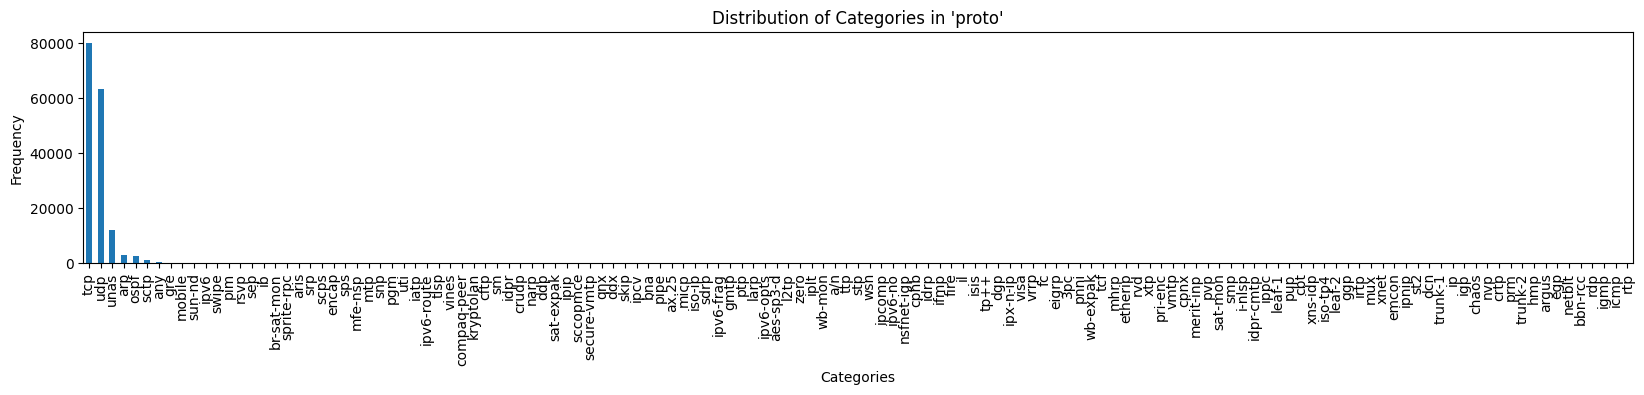

In [11]:
# Determine encoding scheme for 'proto' feature
num_categories = X_train['proto'].nunique()
categories = X_train['proto'].unique();
print(f'Number of unique values in proto: {num_categories}')
print(f'  {categories}') # There's a lot of categories

# Show frequency of unique values:
category_counts = X_train['proto'].value_counts()
print(category_counts)

# Plotting frequency of each 'proto' category
plt.figure(figsize=(20, 3))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in \'proto\'')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate category labels for better readability
plt.show()

### Handling nominal feature: 'state'
Understand the distribution of categories within 'state'

Number of unique values in state: 9
  ['FIN' 'CON' 'INT' 'REQ' 'RST' 'ECO' 'URN' 'PAR' 'no']
state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
URN        1
PAR        1
no         1
Name: count, dtype: int64


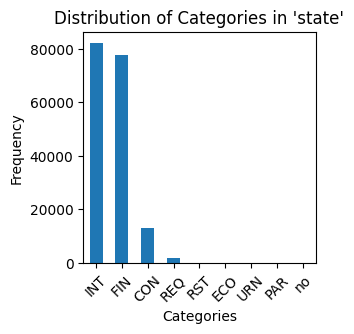

In [12]:
# Determine encoding scheme for 'state' feature
num_categories = X_train['state'].nunique()
categories = X_train['state'].unique();
print(f'Number of unique values in state: {num_categories}')
print(f'  {categories}')

# Show frequency of unique values:
category_counts = X_train['state'].value_counts()
print(category_counts)

# Plotting frequency of each 'state' category
plt.figure(figsize=(3, 3))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in \'state\'')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.show()

### Handling nominal feature: 'service'
Understand the distribution of categories within 'service'

Number of unique values in service: 13
  ['ftp-data' 'dns' '-' 'ftp' 'http' 'ssh' 'smtp' 'pop3' 'radius' 'dhcp'
 'snmp' 'ssl' 'irc']
service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: count, dtype: int64


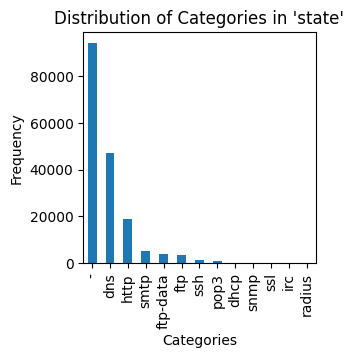

In [13]:
# Determine encoding scheme for 'service' feature
num_categories = X_train['service'].nunique()
categories = X_train['service'].unique();
print(f'Number of unique values in service: {num_categories}')
print(f'  {categories}')

# Show frequency of unique values:
category_counts = X_train['service'].value_counts()
print(category_counts)

# Plotting frequency of each 'service' category
plt.figure(figsize=(3, 3))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in \'state\'')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=90) # Better readability
plt.show()

### Aggregation for 'proto', 'state', and 'service'

In [14]:
nominal_features = ['proto', 'state', 'service']

# If category does not comprise at least 1 percent of total data (can change this), set it to 'other' category
threshold_percentage = 0.005
threshold = X_train.shape[0] * threshold_percentage;

for nf in nominal_features:
    
    # Aggregate for training set
    frequency = X_train[nf].value_counts()
    categories = X_train[nf].unique();
    
    print(f'Performing aggregation for {nf} with threshold percentage: {threshold_percentage}')
    
    X_train[nf] = X_train[nf].apply(lambda x: x if frequency[x] > threshold else 'other')
    
    # See updated categories
    updated_categories = X_train[nf].unique();
    print(f'  Updated {nf} categories for train set: {updated_categories}')
    
    # Apply changes to testing set
    frequency = X_test[nf].value_counts()
    X_test[nf] = X_test[nf].apply(lambda x: x if x in updated_categories else 'other')
    print(f'  Updated {nf} categories for test set: {X_test[nf].unique()}\n')

Performing aggregation for proto with threshold percentage: 0.005
  Updated proto categories for train set: ['tcp' 'udp' 'other' 'unas' 'ospf' 'arp' 'sctp']
  Updated proto categories for test set: ['tcp' 'udp' 'sctp' 'unas' 'other' 'ospf' 'arp']

Performing aggregation for state with threshold percentage: 0.005
  Updated state categories for train set: ['FIN' 'CON' 'INT' 'REQ' 'other']
  Updated state categories for test set: ['FIN' 'INT' 'CON' 'REQ' 'other']

Performing aggregation for service with threshold percentage: 0.005
  Updated service categories for train set: ['ftp-data' 'dns' '-' 'ftp' 'http' 'ssh' 'smtp' 'pop3' 'other']
  Updated service categories for test set: ['pop3' '-' 'dns' 'http' 'ftp-data' 'ftp' 'smtp' 'ssh' 'other']



### Binary Encoding

In [15]:
from category_encoders import BinaryEncoder

# Initialize Binary Encoder
encoder = BinaryEncoder(cols=['proto', 'state', 'service'], handle_unknown='ignore')

# Fit the encoder on the training data
X_train = encoder.fit_transform(X_train)

# Transform the testing data using the same encoder
X_test = encoder.transform(X_test)

print("Encoded Training Data:")
print(X_train)
print("\nEncoded Testing Data:")
print(X_test)

Encoded Training Data:
              dur  proto_0  proto_1  proto_2  service_0  service_1  service_2  \
0        0.058490        0        0        1          0          0          0   
1        0.001275        0        1        0          0          0          1   
2        0.000003        0        1        0          0          0          1   
3        0.000008        0        1        1          0          0          1   
4        1.465454        0        0        1          0          0          1   
...           ...      ...      ...      ...        ...        ...        ...   
175336   0.000006        0        1        0          0          0          1   
175337  59.984226        1        1        0          0          0          1   
175338   0.000017        0        1        0          0          0          1   
175339   0.000009        0        1        0          0          0          1   
175340   0.788248        0        0        1          0          0          1   

    

### Handle Class Imbalances in Training Set
Understand and handle any class imbalances within training set

In [16]:
# Check distribution of the 'label' feature
label_distribution = train_df['label'].value_counts()
print("Distribution of 'label':")
print(label_distribution)

# Check distribution of the 'attack_cat' feature
attack_cat_distribution = train_df['attack_cat'].value_counts()
print("Distribution of 'attack_cat':")
print(attack_cat_distribution)

Distribution of 'label':
label
1    119341
0     56000
Name: count, dtype: int64
Distribution of 'attack_cat':
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


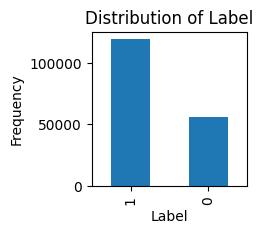

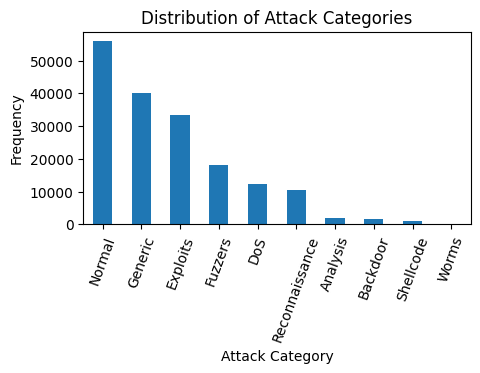

In [17]:
# Plot for 'label' distribution
plt.figure(figsize=(2, 2))
label_distribution.plot(kind='bar')
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

# Plot for 'attack_cat' distribution
plt.figure(figsize=(5, 2.5))
attack_cat_distribution.plot(kind='bar')
plt.title('Distribution of Attack Categories')
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.xticks(rotation=70) # Readability
plt.show()

In [18]:
from imblearn.over_sampling import SMOTE

# Try SMOTE For Handling Class Imbalances
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

### Check New Distribution of 'label'

Distribution of 'label':
label
0    119341
1    119341
Name: count, dtype: int64


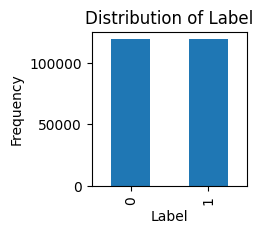

In [19]:
# Check distribution of the 'label' feature
label_distribution = y_train.value_counts()
print("Distribution of 'label':")
print(label_distribution)

# Plot for 'label' distribution
plt.figure(figsize=(2, 2))
label_distribution.plot(kind='bar')
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

### PCA -- This is making things worse?

In [20]:
# from sklearn.preprocessing import StandardScaler

# # Standardize the features
# scaler = StandardScaler()
# # Train
# X_train = scaler.fit_transform(X_train)
# # Test
# X_test = scaler.transform(X_test)

In [21]:
# from sklearn.decomposition import PCA

# # Use PCA and specify the number of components
# pca = PCA(n_components=0.999)  # retain 99.9% of the variance or specify a number of components directly
# # Train
# X_train = pca.fit_transform(X_train)
# # Test
# X_test = pca.transform(X_test)

# # Check the shape of the new data array and explained variance
# print("New shape of train data:", X_train.shape)
# print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

## Training and Testing

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold

### Random Forest (Bagging)

In [23]:
print('Running: Random Forest Classifier...')

rf_clf = RandomForestClassifier(
    n_estimators=100, # default=100
    max_depth=12, # default=None
    min_samples_split=2, # default=2
    min_samples_leaf=1, # default=1
    max_features='sqrt', # default="sqrt"
    bootstrap=True, # default=True
    class_weight=None # default=None
)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the Random Forest classifier:', accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

Running: Random Forest Classifier...
Accuracy of the Random Forest classifier: 0.9073871641646019
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     37000
           1       0.88      0.97      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.92      0.90      0.91     82332
weighted avg       0.91      0.91      0.91     82332



### Random Forest + K-Fold Cross-Validation

In [24]:
# print('Running: Random Forest Classifier w/ K-Fold Cross Validation (Training set only)...')

# # Setting up K-Fold
# kf = KFold(n_splits=5, shuffle=True, random_state=0)
# cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=kf, scoring='accuracy')

# # Results from cross-validation
# print("Cross-validation scores:", cv_scores)
# print("Mean cross-validation score:", np.mean(cv_scores))
# print("Standard deviation of CV scores:", np.std(cv_scores))

### Ensemble (Bagging)

In [25]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print('Running: Ensemble (Bagging) w/ Decision Trees...')

dtc = DecisionTreeClassifier(max_depth=12)
clf = AdaBoostClassifier(estimator=dtc,
                         algorithm='SAMME',
                         n_estimators=10,
                         random_state=0)
clf.fit(X_train, y_train) # Training
y_pred = clf.predict(X_test) # Predict

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Boosting w/ Decision Trees:', accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

Running: Ensemble (Bagging) w/ Decision Trees...
Accuracy of Boosting w/ Decision Trees: 0.8766457756400914
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     37000
           1       0.84      0.96      0.90     45332

    accuracy                           0.88     82332
   macro avg       0.89      0.87      0.87     82332
weighted avg       0.88      0.88      0.87     82332

